In [1]:
import glob
import time
import numpy
import crowdsource
import regions
import numpy as np
from functools import cache
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import wcs
from astropy import table
from astropy import stats
from astropy import units as u
from astropy.nddata import NDData
from astropy.io import fits
from scipy import ndimage
import requests
import requests.exceptions
import urllib3
import urllib3.exceptions
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, extract_stars, EPSFStars, EPSFModel
try:
    # version >=1.7.0, doesn't work: the PSF is broken
    from photutils.psf import PSFPhotometry, IterativePSFPhotometry, SourceGrouper
except:
    # version 1.6.0, which works
    from photutils.psf import BasicPSFPhotometry as PSFPhotometry, IterativelySubtractedPSFPhotometry as IterativePSFPhotometry, DAOGroup as SourceGrouper
try:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D, LocalBackground
except:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D
    from photutils.background import MMMBackground as LocalBackground

from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars

import warnings
from astropy.utils.exceptions import AstropyWarning, AstropyDeprecationWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=AstropyDeprecationWarning)

from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

from astroquery.svo_fps import SvoFps

import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

import os
print("Importing webbpsf", flush=True)
import webbpsf
from webbpsf.utils import to_griddedpsfmodel
import datetime


Importing webbpsf


In [2]:
from scipy.spatial import KDTree
import scipy
import scipy.ndimage

In [3]:
filt = filtername = 'f444w'
#filt = filtername = 'f444w'

In [4]:
basepath = '/blue/adamginsburg/adamginsburg/jwst/brick/'

In [5]:
im1 = fits.open(f'{basepath}/F444W/pipeline/jw01182-o004_t001_nircam_clear-f444w-merged_i2d.fits')
obsdate = im1[0].header['DATE-OBS']
module = 'merged'
data = im1['SCI'].data[:400,:400]
err = im1['ERR'].data[:400,:400]

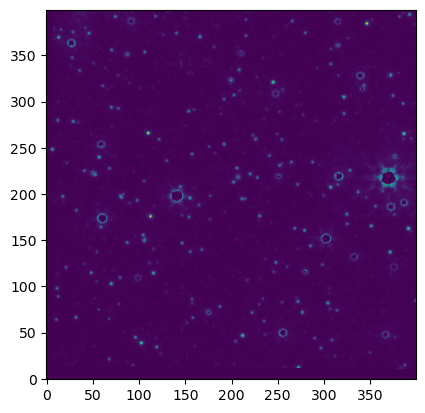

In [6]:
# basic check that the corner is OK.... (We need to use a corner for this test b/c the PSF grid is tuned for corners)
pl.imshow(data)

# PSF check

In [7]:
oversample = 1
proposal_id = 1182
field = '004'

blur_ = ''
dao_psf_model = to_griddedpsfmodel(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample{oversample}{blur_}.fits')
dao_psf_model.flux.min = 0

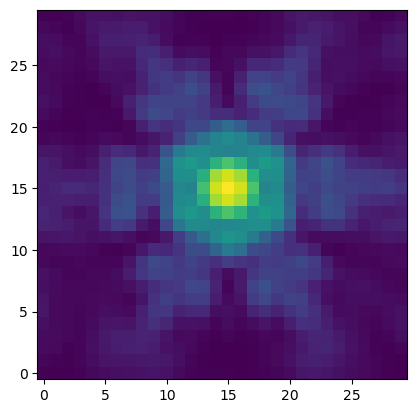

In [8]:
yy, xx = np.mgrid[-15:15,-15:15]
mod_ = dao_psf_model(xx, yy)
pl.imshow(mod_, norm=simple_norm(mod_, stretch='log'));

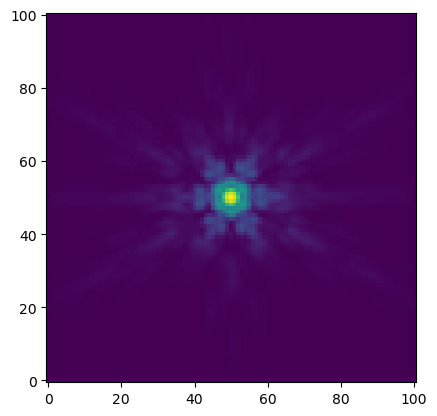

In [9]:
#o1 = fits.getdata(f'{basepath}/psfs/F410M_2221_001_merged_PSFgrid_oversample1.fits')
o1 = fits.getdata(f'{basepath}/psfs/F444W_1182_004_merged_PSFgrid_oversample1.fits')
pl.imshow(o1[0], norm=simple_norm(o1, stretch='log'));

# Load data / errors

In [10]:
# crowdsource uses inverse-sigma, not inverse-variance
weight = err**-1
maxweight = np.percentile(weight[np.isfinite(weight)], 95)
minweight = np.percentile(weight[np.isfinite(weight)], 5)
badweight =  np.percentile(weight[np.isfinite(weight)], 1)
weight[err < 1e-5] = 0
#weight[(err == 0) | (wht == 0)] = np.nanmedian(weight)
weight[np.isnan(weight)] = 0
bad = np.isnan(weight) | (data == 0) | np.isnan(data) | (weight == 0) | (err == 0) | (data < 1e-5)

weight[weight > maxweight] = maxweight
weight[weight < minweight] = minweight
# it seems that crowdsource doesn't like zero weights
# may have caused broked f466n? weight[bad] = badweight
weight[bad] = minweight
# crowdsource explicitly handles weight=0, so this _should_ work.
weight[bad] = 0

# Expand bad pixel zones for dq
bad_for_dq = ndimage.binary_dilation(bad, iterations=2)
print(f"Total bad pixels = {bad.sum()}, total bad for dq={bad_for_dq.sum()}")

mask = bad

mask = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(mask, iterations=1), iterations=1)
mask = scipy.ndimage.binary_erosion(scipy.ndimage.binary_dilation(mask, iterations=1), iterations=1)

/scratch/local/36705836/ipykernel_1367978/2819246680.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  weight = err**-1


Total bad pixels = 27509, total bad for dq=55153


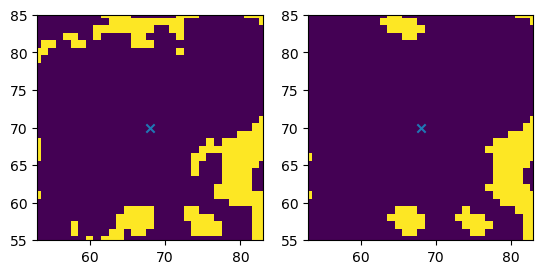

In [11]:
pl.subplot(1,2,1).imshow(bad)
pl.scatter(68, 70, marker='x')
pl.axis([68-15,68+15, 70-15, 70+15]);
pl.subplot(1,2,2).imshow(mask)
pl.scatter(68, 70, marker='x')
pl.axis([68-15,68+15, 70-15, 70+15]);

# Start tests

In [12]:
print(f"Starting filter {filtername}", flush=True)
fwhm_tbl = Table.read(f'{basepath}/reduction/fwhm_table.ecsv')
row = fwhm_tbl[fwhm_tbl['Filter'] == filtername.upper()]
fwhm = fwhm_arcsec = float(row['PSF FWHM (arcsec)'][0])
fwhm_pix = float(row['PSF FWHM (pixel)'][0])
fwhm_pix

Starting filter f444w


2.302

In [13]:
grouper = SourceGrouper(2 * fwhm_pix)
mmm_bkg = MMMBackground()

filtered_errest = stats.sigma_clipped_stats(data, stdfunc='mad_std')
print(f'Error estimate for DAO from stats.: {filtered_errest}', flush=True)
filtered_errest = np.nanmedian(err)
print(f'Error estimate for DAO from median(err): {filtered_errest}', flush=True)

Error estimate for DAO from stats.: (4.3175693, 3.2683306, 4.6356134)
Error estimate for DAO from median(err): 0.10964541137218475


In [14]:
daofind_tuned = DAOStarFinder(threshold=5 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                              sharplo=0.30, sharphi=1.40,
                              exclude_border=True
                             )
print("Finding stars with daofind_tuned", flush=True)
finstars = daofind_tuned(np.nan_to_num(data), mask=mask)

print(f"Found {len(finstars)} with daofind_tuned", flush=True)
# for diagnostic plotting convenience
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

Finding stars with daofind_tuned
Found 3205 with daofind_tuned


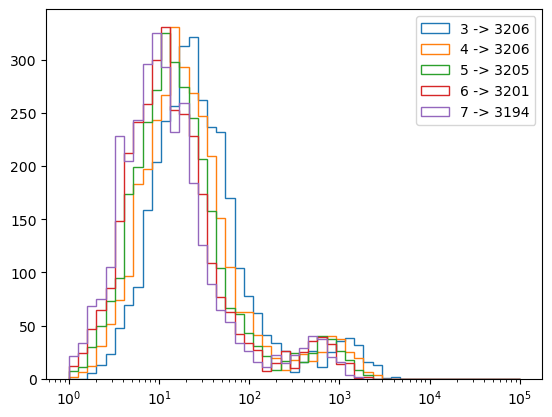

In [15]:
for threshold in (3,4,5,6,7):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=0.30, sharphi=1.40,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data), mask=mask)
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=f'{threshold} -> {len(finstars_test)}')
pl.xscale('log');
pl.legend(loc='best');

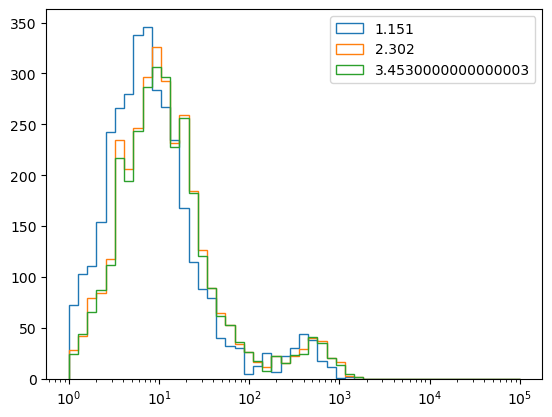

In [16]:
for fwhm in (0.5*fwhm_pix, 1*fwhm_pix, 1.5*fwhm_pix):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm, roundhi=1.0, roundlo=-1.0,
                                  sharplo=0.30, sharphi=1.40,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=fwhm)
pl.xscale('log');
pl.legend(loc='best');

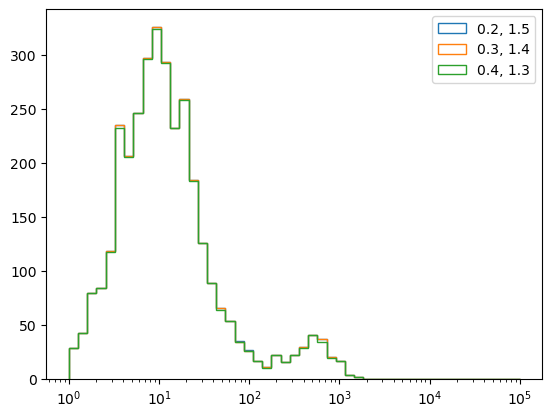

In [17]:
for sharplo, sharphi in ((0.2, 1.5), (0.3, 1.4), (0.4, 1.3)):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=sharplo, sharphi=sharphi,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=f'{sharplo}, {sharphi}')
pl.xscale('log');
pl.legend(loc='best');

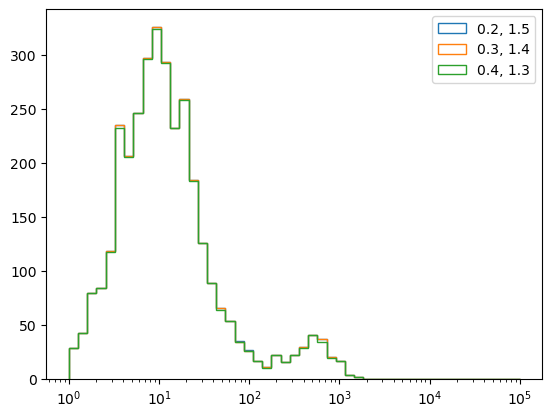

In [18]:
for sharplo, sharphi in ((0.2, 1.5), (0.3, 1.4), (0.4, 1.3)):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=sharplo, sharphi=sharphi,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=f'{sharplo}, {sharphi}')
pl.xscale('log');
pl.legend(loc='best');

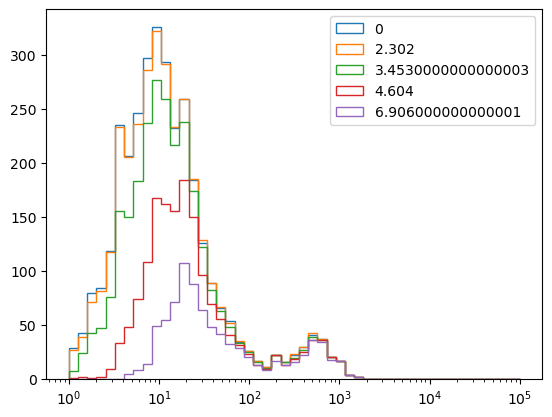

In [19]:
for min_separation in (0, fwhm_pix, 1.5*fwhm_pix, 2*fwhm_pix, 3*fwhm_pix):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=0.3, sharphi=1.4,
                                  exclude_border=True,
                                 min_separation=min_separation,
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=min_separation)
pl.xscale('log');
pl.legend(loc='best');

In [20]:
# I thought that daofind_tuned flux would be flux_init, but this is off by 30x!  That's WAY too much.
daofind_tuned(o1[0]*100)['flux']/100, o1[0].sum()

(<Column name='flux' dtype='float64' length=1>
 0.18315858257646808,
 1.0)

In [21]:
data.shape, data.size, mask.sum(), bad.sum()

((400, 400), 160000, 23128, 27509)

# BASIC

In [22]:
phot = PSFPhotometry(finder=daofind_tuned,#finder_maker(),
                     #grouper=grouper,
                     #localbkg_estimator=None, # must be none or it un-saturates pixels
                     localbkg_estimator=LocalBackground(5, 15),
                     psf_model=dao_psf_model,
                     fitter=LevMarLSQFitter(),
                     fit_shape=(5, 5),
                     aperture_radius=2*fwhm_pix,
                     progress_bar=True,
                    )

print("About to do BASIC photometry....")
t0 = time.time()

# mask causes the error 'ValueError: For one or more sources, the number of data points available to fit is less than the number of fit parameters. This could be due to a source(s) near the edge of the detector or if it has few unmasked pixels. Please check the input mask or source positions.'
# for f444w.  This is certainly a bug; daofind shouldn't put stars there.
result = phot(np.nan_to_num(data), mask=mask)
print(f"Done with BASIC photometry.  len(result)={len(result)} dt={time.time() - t0}")

About to do BASIC photometry....


Fit source/group:   0%|          | 0/3205 [00:00<?, ?it/s]

Done with BASIC photometry.  len(result)=3205 dt=157.70295190811157


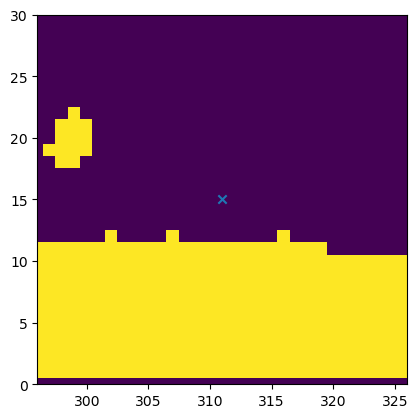

In [23]:
# this cell is intended as a debug if/when the above mask'd phot fails

pl.imshow(mask)
pl.scatter(311, 15, marker='x')
pl.axis([311-15,311+15, 0, 30]);

In [24]:
grouper = SourceGrouper(2 * fwhm_pix)
groups = grouper(finstars['x'], finstars['y'])
np.unique(groups).size, len(finstars), np.bincount(groups).max()

(2007, 3205, 9)

In [25]:
grouper = SourceGrouper(2 * fwhm_pix)
phot_g = PSFPhotometry(finder=daofind_tuned,#finder_maker(),
                     grouper=grouper,
                     #localbkg_estimator=None, # must be none or it un-saturates pixels
                     localbkg_estimator=LocalBackground(5, 15),
                     psf_model=dao_psf_model,
                     fitter=LevMarLSQFitter(),
                     fit_shape=(5, 5),
                     aperture_radius=2*fwhm_pix,
                     progress_bar=True,
                    )

print("About to do BASIC photometry....")
t0 = time.time()
result_g = phot_g(np.nan_to_num(data), mask=mask)
print(f"Done with BASIC photometry.  len(result)={len(result)} dt={time.time() - t0}")


About to do BASIC photometry....


Fit source/group:   0%|          | 0/2007 [00:00<?, ?it/s]

Done with BASIC photometry.  len(result)=3205 dt=176.35756516456604


In [26]:
result[:3]

<QTable length=3>
  id  group_id group_size     local_bkg            x_init             y_init           flux_init            x_fit        ...        x_err               y_err             flux_err      npixfit         qfit                cfit         flags
int64  int64     int64         float64            float64            float64            float64            float64       ...       float64             float64            float64        int64        float64             float64        int64
----- -------- ---------- ------------------ ------------------ ------------------ ------------------ ------------------ ... ------------------- ------------------- ------------------ ------- ------------------- -------------------- -----
    1        1          1 2.1377172470092773  344.0439496017699 11.737388872253854 125.71297147472941 342.02586835561925 ... 0.25208523025767465  0.2334460121849769 7.3522806141641155      20  0.2994395105192899 0.017862081962013623     1
    2        2          1 3.0903027057647705 374.37391139849154 11.396975873855512  286.7125379467746 374.65069699444115 ...  0.5377363115620325  1.6516578176781447 121.31529339788973      15 0.32231564725503814  0.00983388302231036     1
    3        3          1  5.041902542114258 385.88165041316785 12.344362257325127  4732.038469181808 387.23231455200835 ... 0.18606382304956012 0.28580592489504364  548.3928069038714      20  0.2764642564665637  0.01809095840563186     1

In [27]:
residual = phot.make_residual_image(data, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/3205 [00:00<?, ?it/s]

In [28]:
model = phot.make_model_image(data.shape, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/3205 [00:00<?, ?it/s]

In [29]:
model_g = phot_g.make_model_image(data.shape, (31, 31), include_localbkg=False)
residual_g = data - model_g

Add model sources:   0%|          | 0/3205 [00:00<?, ?it/s]

In [30]:
phot_biggerfootprint = PSFPhotometry(finder=daofind_tuned,#finder_maker(),
                     #grouper=grouper,
                     #localbkg_estimator=None, # must be none or it un-saturates pixels
                     localbkg_estimator=LocalBackground(5, 15),
                     psf_model=dao_psf_model,
                     fitter=LevMarLSQFitter(),
                     fit_shape=(7, 7),
                     aperture_radius=2.2*fwhm_pix,
                     progress_bar=True,
                    )

print("About to do BASIC photometry....")
t0 = time.time()
try:
    result_biggerfootprint = phot_biggerfootprint(np.nan_to_num(data), mask=mask)
except Exception as ex:
    print(ex)
    result_biggerfootprint = phot_biggerfootprint(np.nan_to_num(data))
model_biggerfootprint = phot_biggerfootprint.make_model_image(data.shape, (31, 31), include_localbkg=False)
residual_biggerfootprint = data - model_biggerfootprint
print(f"Done with BASIC photometry.  len(result)={len(result)} dt={time.time() - t0}")


About to do BASIC photometry....


Fit source/group:   0%|          | 0/3205 [00:00<?, ?it/s]

Add model sources:   0%|          | 0/3205 [00:00<?, ?it/s]

Done with BASIC photometry.  len(result)=3205 dt=54.08754062652588


In [31]:
dist, ind = KDTree(np.array([result['x_fit'], result['y_fit']]).T).query(np.array([result['x_fit'], result['y_fit']]).T, 2) 
close_neighbor = ind[:,1][dist[:,1] < 1]

dist, ind = KDTree(np.array([result_g['x_fit'], result_g['y_fit']]).T).query(np.array([result_g['x_fit'], result_g['y_fit']]).T, 2) 
close_neighbor_g = ind[:,1][dist[:,1] < 1]

dist, ind = KDTree(np.array([result_biggerfootprint['x_fit'], result_biggerfootprint['y_fit']]).T).query(np.array([result_biggerfootprint['x_fit'], result_biggerfootprint['y_fit']]).T, 2) 
close_neighbor_biggerfootprint = ind[:,1][dist[:,1] < 1]

len(close_neighbor), len(close_neighbor_g), len(close_neighbor_biggerfootprint)

(608, 58, 874)

In [32]:
close_neighbor_biggerfootprint.shape

(874,)

### Default

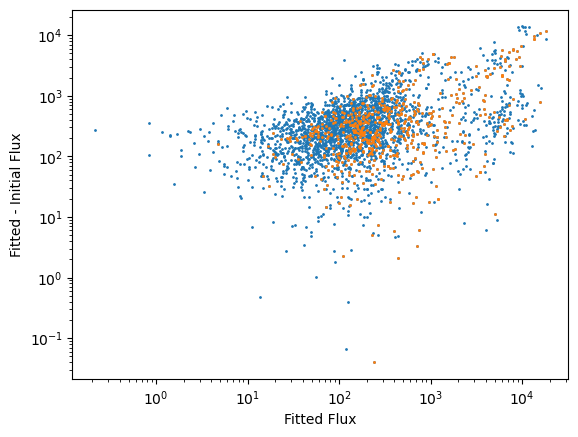

In [33]:
pl.scatter(result['flux_fit'], np.abs(result['flux_fit'] - result['flux_init']), s=1)
pl.scatter(result['flux_fit'][close_neighbor], np.abs(result['flux_fit'] - result['flux_init'])[close_neighbor], s=1)
pl.loglog()
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial Flux");

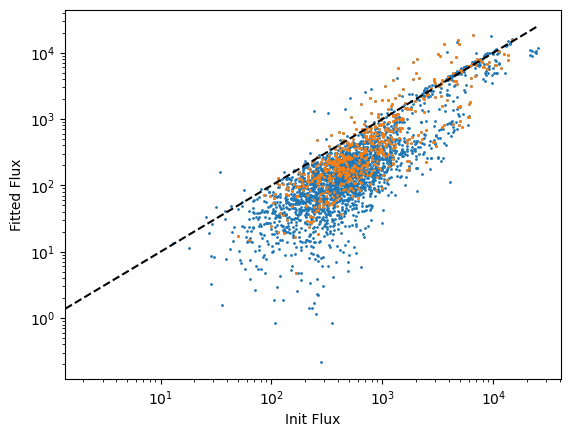

In [34]:
pl.scatter(result['flux_init'], result['flux_fit'] , s=1)
pl.scatter(result['flux_init'][close_neighbor], result['flux_fit'][close_neighbor] , s=1)
pl.xlabel("Init Flux")
pl.ylabel("Fitted Flux")
pl.loglog()
pl.plot([0,25000],[0,25000], 'k--');

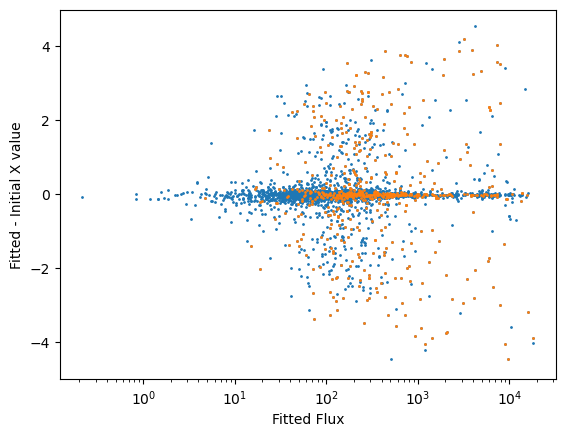

In [35]:
pl.scatter(result['flux_fit'], result['x_fit'] - result['x_init'], s=1)
pl.scatter(result['flux_fit'][close_neighbor], (result['x_fit'] - result['x_init'])[close_neighbor], s=1)
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial X value")
pl.ylim(-5,5)
pl.semilogx();

### Grouped

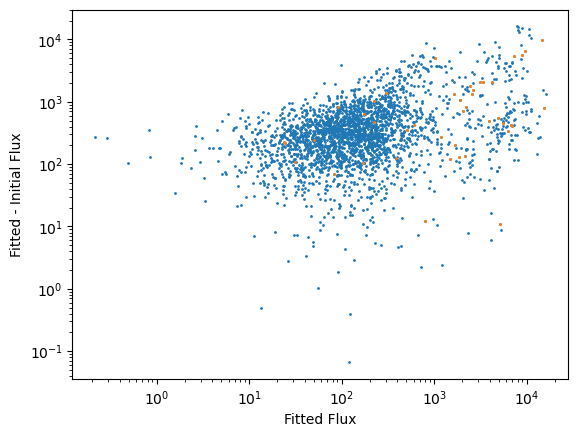

In [36]:
pl.scatter(result_g['flux_fit'], np.abs(result_g['flux_fit'] - result_g['flux_init']), s=1)
pl.scatter(result_g['flux_fit'][close_neighbor_g], np.abs(result_g['flux_fit'] - result_g['flux_init'])[close_neighbor_g], s=1)
pl.loglog()
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial Flux");

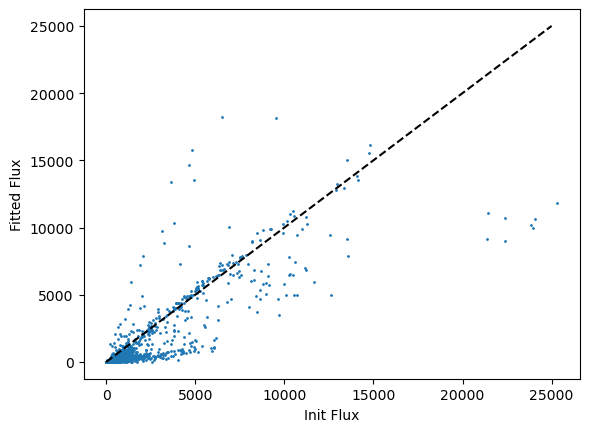

In [37]:
pl.scatter(result_g['flux_init'], result['flux_fit'] , s=1)
pl.xlabel("Init Flux")
pl.ylabel("Fitted Flux")
pl.plot([0,25000],[0,25000], 'k--');

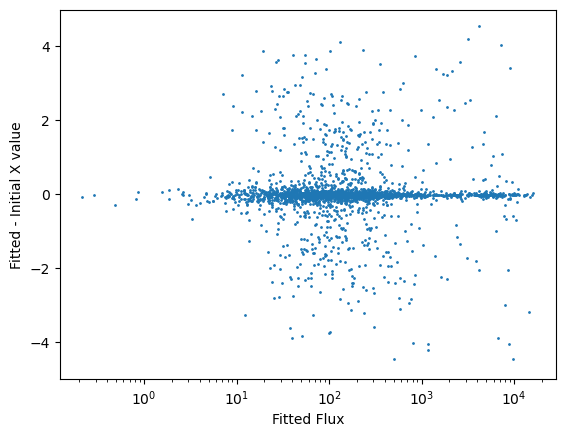

In [38]:
pl.scatter(result_g['flux_fit'], result['x_fit'] - result['x_init'], s=1)
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial X value")
pl.ylim(-5,5);
pl.semilogx();

### Bigger Footprint

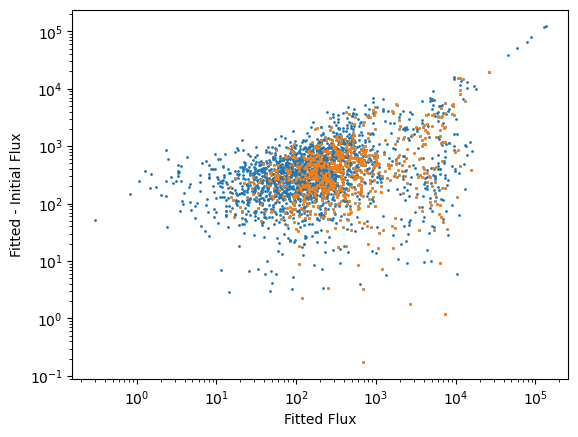

In [39]:
pl.scatter(result_biggerfootprint['flux_fit'], np.abs(result_biggerfootprint['flux_fit'] - result_biggerfootprint['flux_init']), s=1)
pl.scatter(result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint], np.abs(result_biggerfootprint['flux_fit'] - result_biggerfootprint['flux_init'])[close_neighbor_biggerfootprint], s=1)
pl.loglog()
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial Flux");

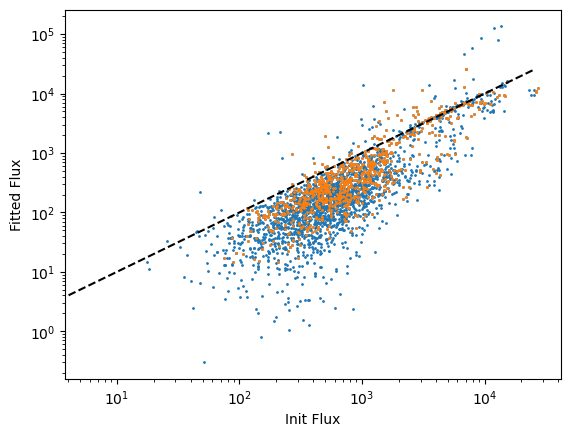

In [40]:
pl.scatter(result_biggerfootprint['flux_init'], result_biggerfootprint['flux_fit'] , s=1)
pl.scatter(result_biggerfootprint['flux_init'][close_neighbor_biggerfootprint], result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint] , s=1)
pl.xlabel("Init Flux")
pl.ylabel("Fitted Flux")
pl.loglog()
pl.plot([0,25000],[0,25000], 'k--');

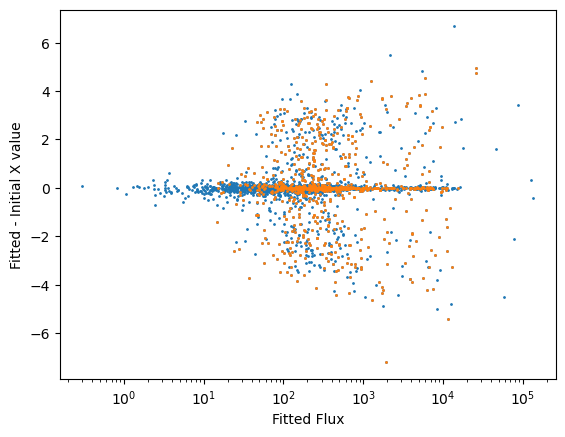

In [41]:
pl.scatter(result_biggerfootprint['flux_fit'], result_biggerfootprint['x_fit'] - result_biggerfootprint['x_init'], s=1)
pl.scatter(result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint], (result_biggerfootprint['x_fit'] - result_biggerfootprint['x_init'])[close_neighbor_biggerfootprint], s=1)
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial X value")
pl.semilogx();

### Histograms

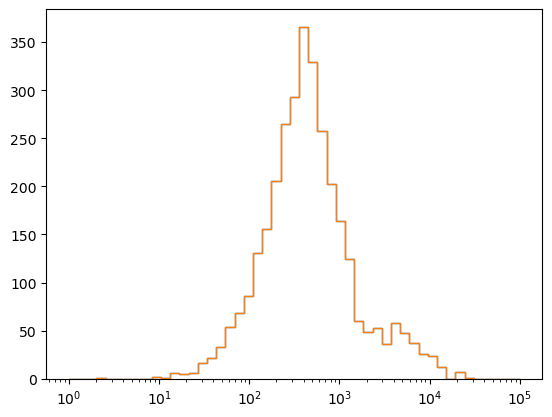

In [42]:
pl.hist(result['flux_init'], bins=np.logspace(0,5), histtype='step')
pl.hist(result_g['flux_init'], bins=np.logspace(0,5), histtype='step')
pl.xscale('log');

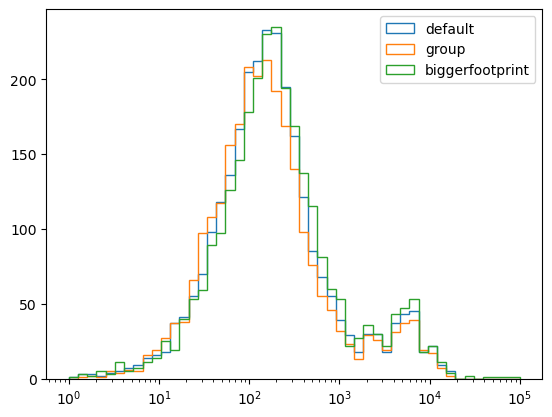

In [43]:
pl.hist(result['flux_fit'], bins=np.logspace(0,5), histtype='step', label='default')
pl.hist(result_g['flux_fit'], bins=np.logspace(0,5), histtype='step', label='group')
pl.hist(result_biggerfootprint['flux_fit'], bins=np.logspace(0,5), histtype='step', label='biggerfootprint')
pl.xscale('log');
pl.legend(loc='best');

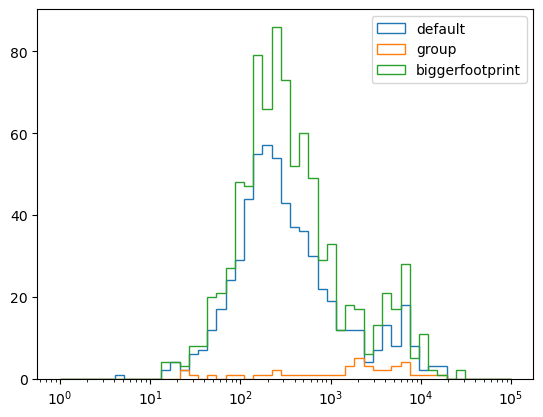

In [44]:
pl.hist(result['flux_fit'][close_neighbor], bins=np.logspace(0,5), histtype='step', label='default')
pl.hist(result_g['flux_fit'][close_neighbor_g], bins=np.logspace(0,5), histtype='step', label='group')
pl.hist(result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint], bins=np.logspace(0,5), histtype='step', label='biggerfootprint')
pl.xscale('log');
pl.legend(loc='best');

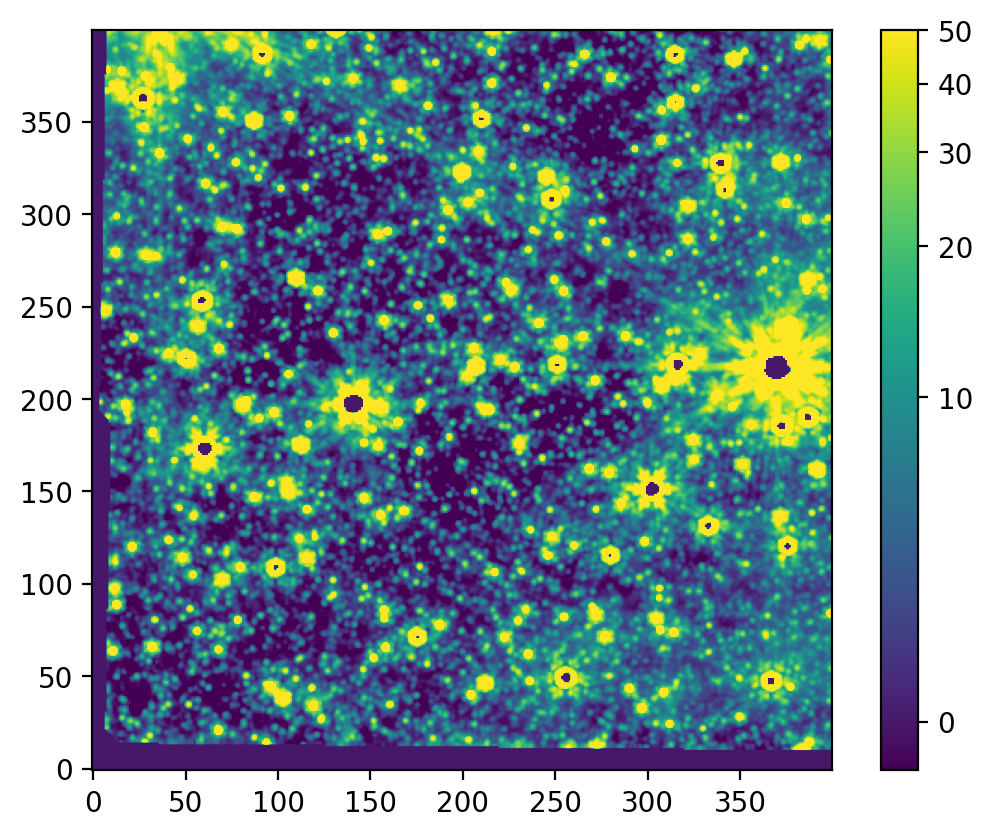

In [60]:
pl.figure(dpi=200)
pl.imshow(data, norm=simple_norm(data, min_cut=-1, max_cut=50, stretch='asinh'))
pl.colorbar();

/scratch/local/36705836/ipykernel_1367978/1092630184.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  pl.scatter((result['x_fit'])[s1], (result['y_fit'])[s1], marker='x', color='red', cmap='jet',
/scratch/local/36705836/ipykernel_1367978/1092630184.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  pl.scatter((result['x_fit'])[s2], (result['y_fit'])[s2], marker='x', color='blue', cmap='jet',


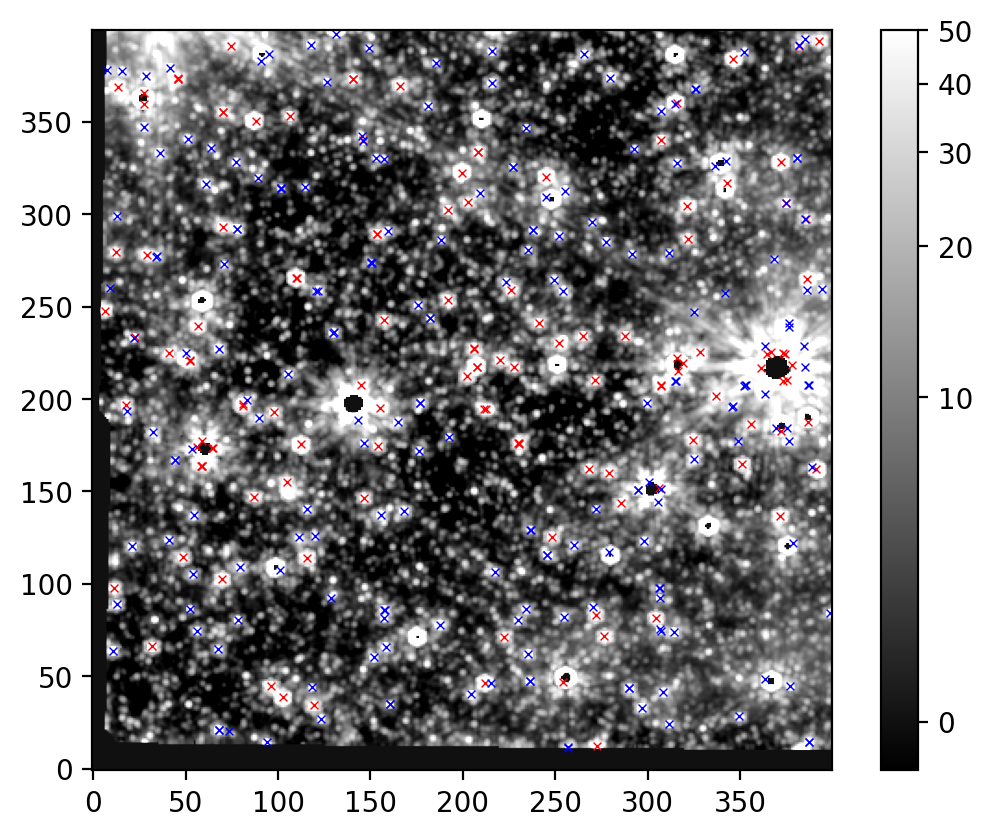

In [73]:
pl.figure(dpi=200)
pl.imshow(data, norm=simple_norm(data, min_cut=-1, max_cut=50, stretch='asinh'), cmap='gray')
pl.colorbar();
s1 = result['flux_fit'] > 5000
pl.scatter((result['x_fit'])[s1], (result['y_fit'])[s1], marker='x', color='red', cmap='jet',
           linewidths=0.5, s=8)
s2 = (result['flux_fit'] < 5000) & (result['flux_fit'] > 1000)
pl.scatter((result['x_fit'])[s2], (result['y_fit'])[s2], marker='x', color='blue', cmap='jet',
           linewidths=0.5, s=8);

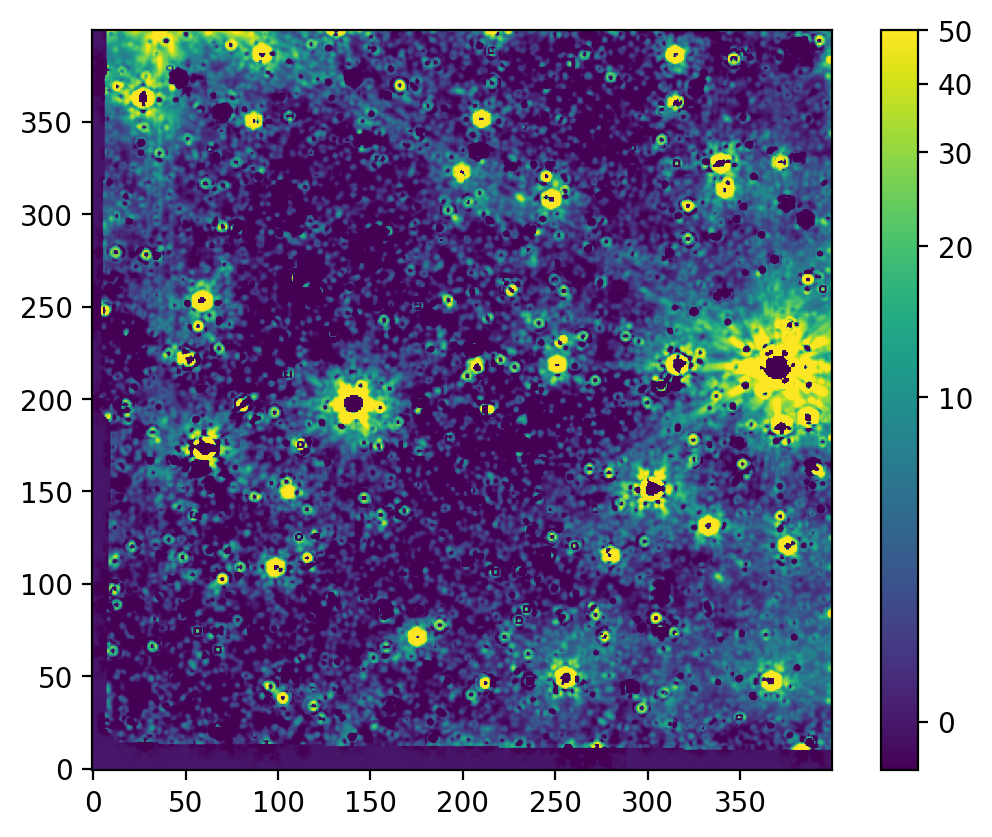

In [61]:
pl.figure(dpi=200)
pl.imshow(residual, norm=simple_norm(residual, min_cut=-1, max_cut=50, stretch='asinh'))
pl.colorbar();

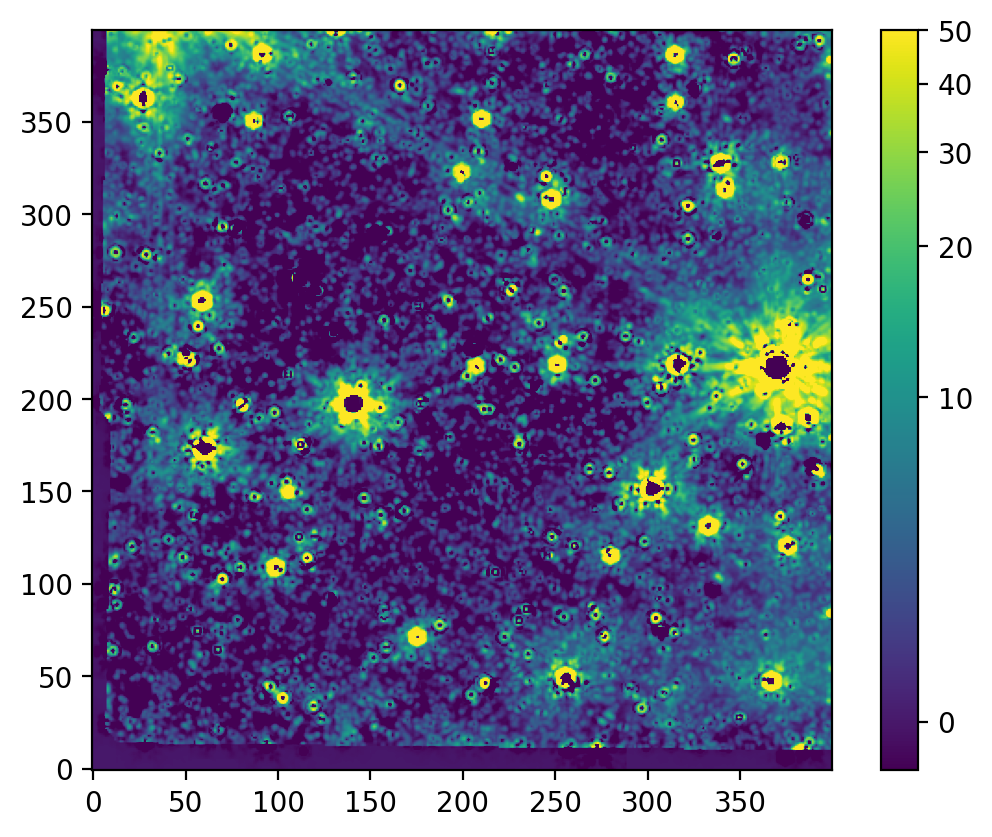

In [62]:
pl.figure(dpi=200)
pl.imshow(residual_g, norm=simple_norm(residual_g, min_cut=-1, max_cut=50, stretch='asinh'))
pl.colorbar();

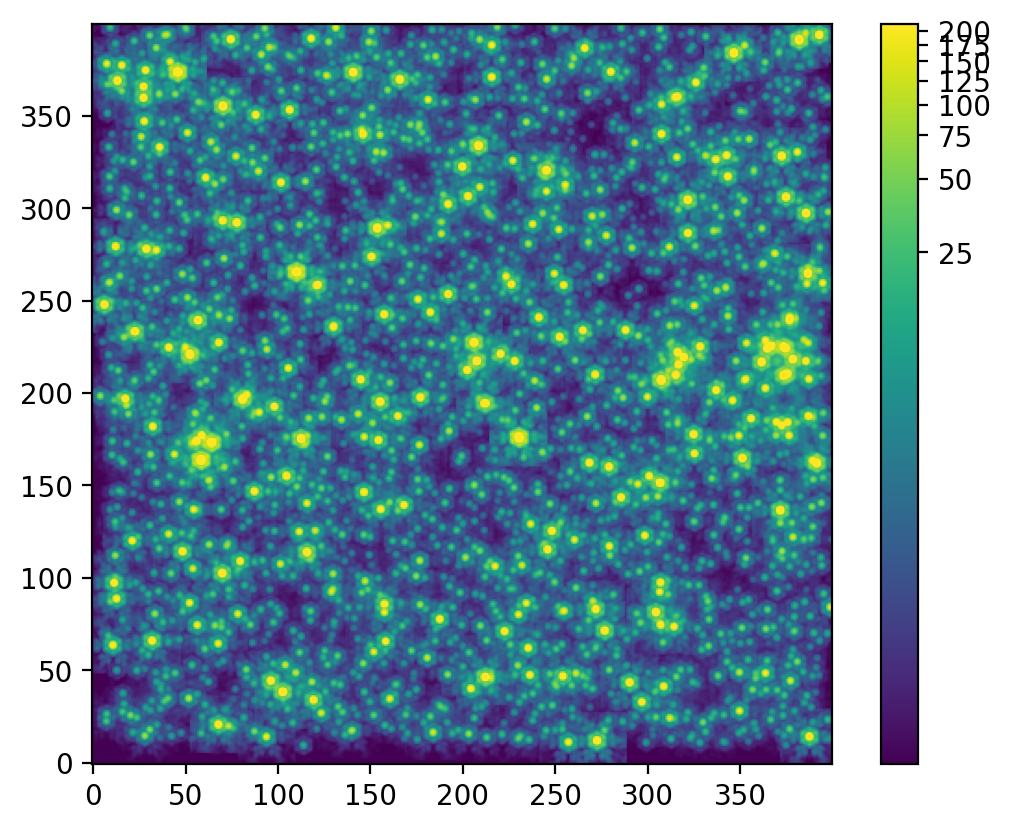

In [48]:
pl.figure(dpi=200)
pl.imshow(model, norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();

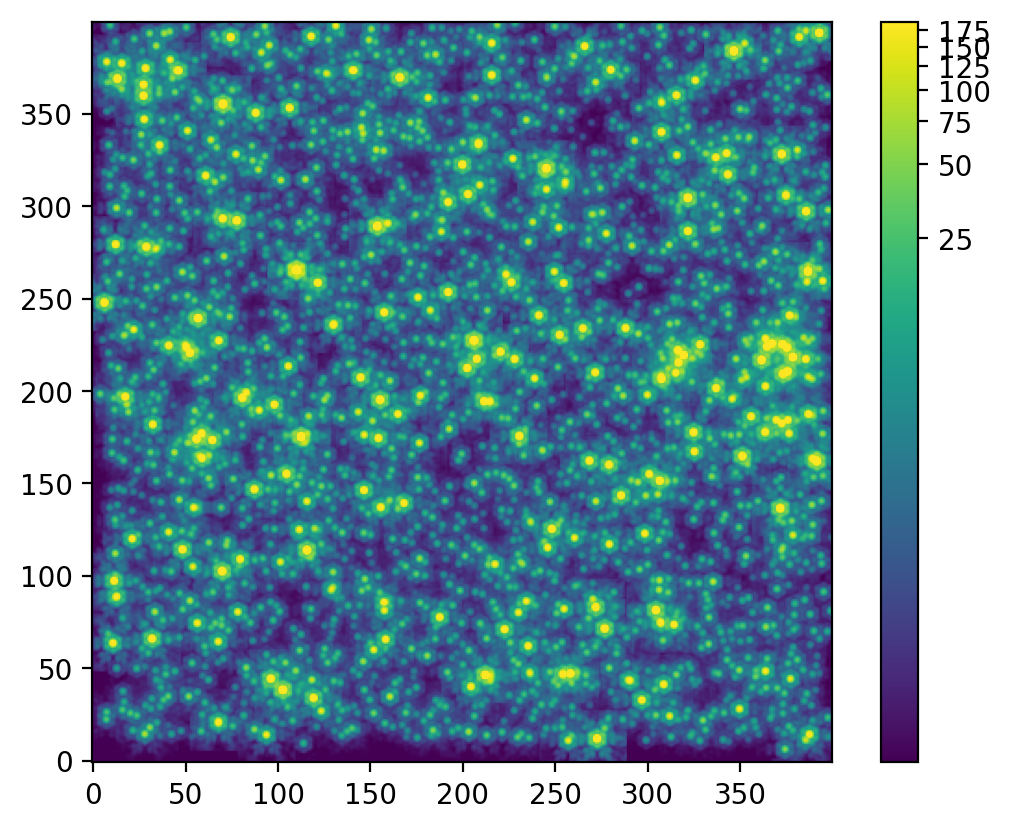

In [49]:
pl.figure(dpi=200)
pl.imshow(model_g, norm=simple_norm(model_g, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();

In [50]:
xl,xu,yl,yu = 100,300,200,400
slc = slice(yl,yu), slice(xl,xu)

/scratch/local/36705836/ipykernel_1367978/2459679924.py:4: RuntimeWarning: divide by zero encountered in log10
  pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', c=np.log10(result['flux_fit']), cmap='jet',


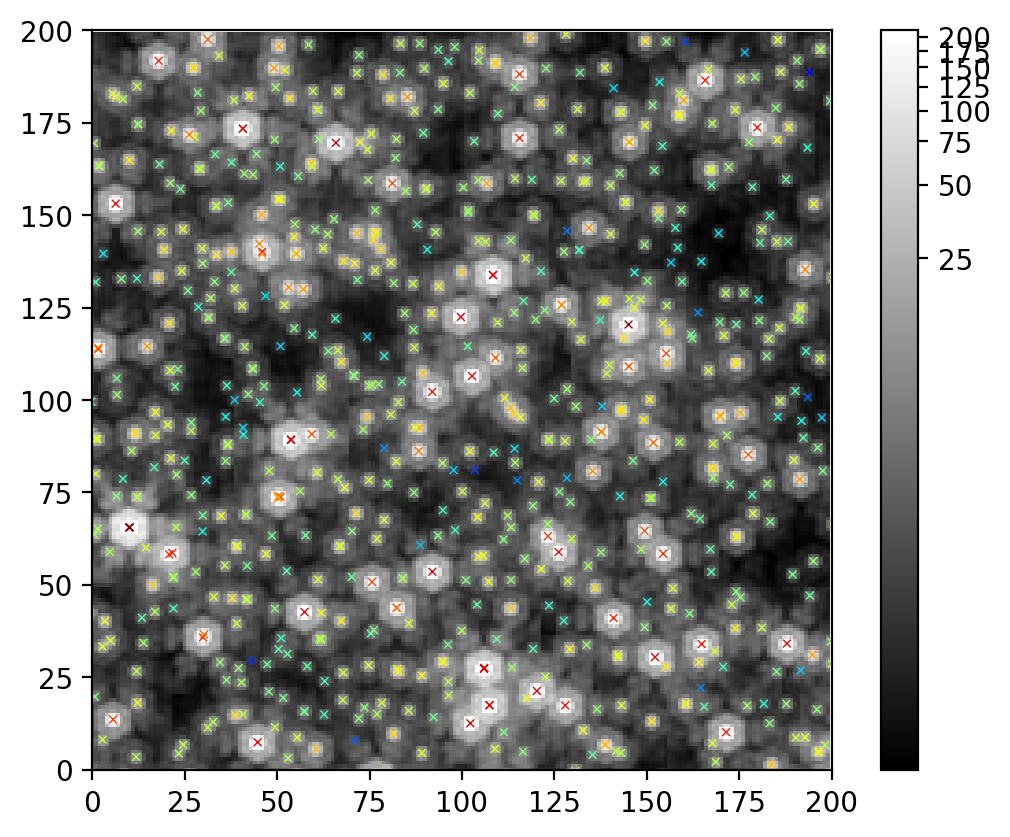

In [68]:
pl.figure(dpi=200)
pl.imshow(model[slc], norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'), cmap='gray')
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', c=np.log10(result['flux_fit']), cmap='jet',
           linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

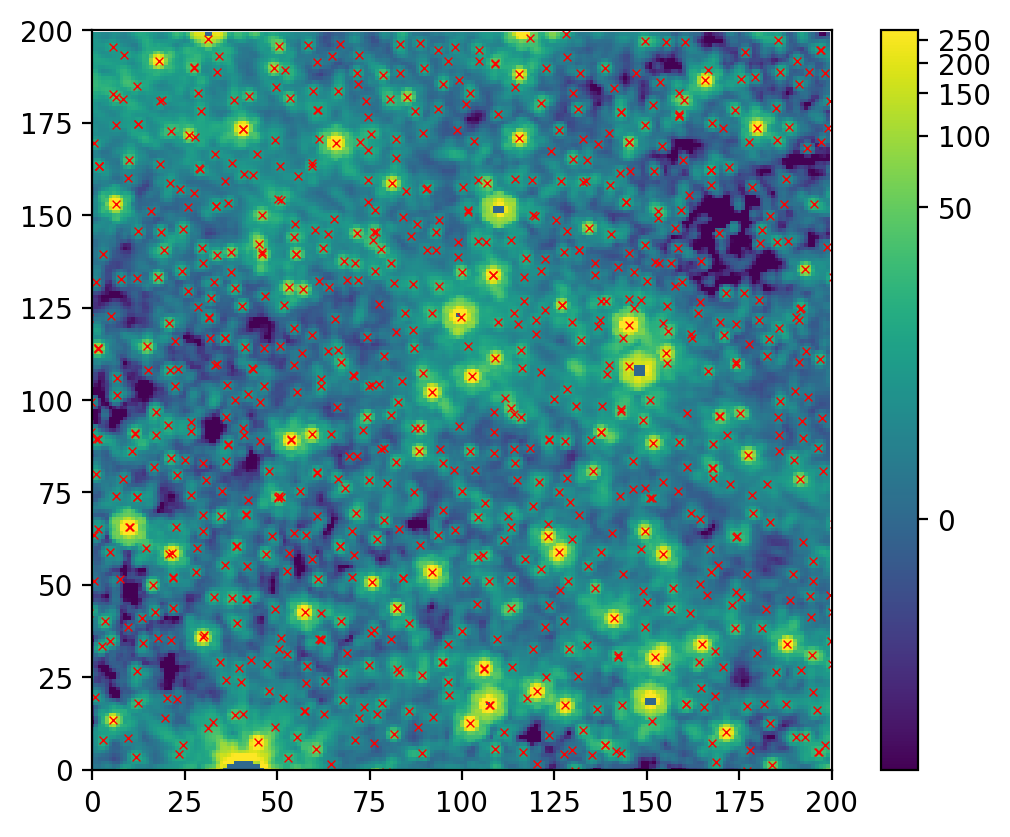

In [52]:
pl.figure(dpi=200)
pl.imshow(data[slc], norm=simple_norm(data, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

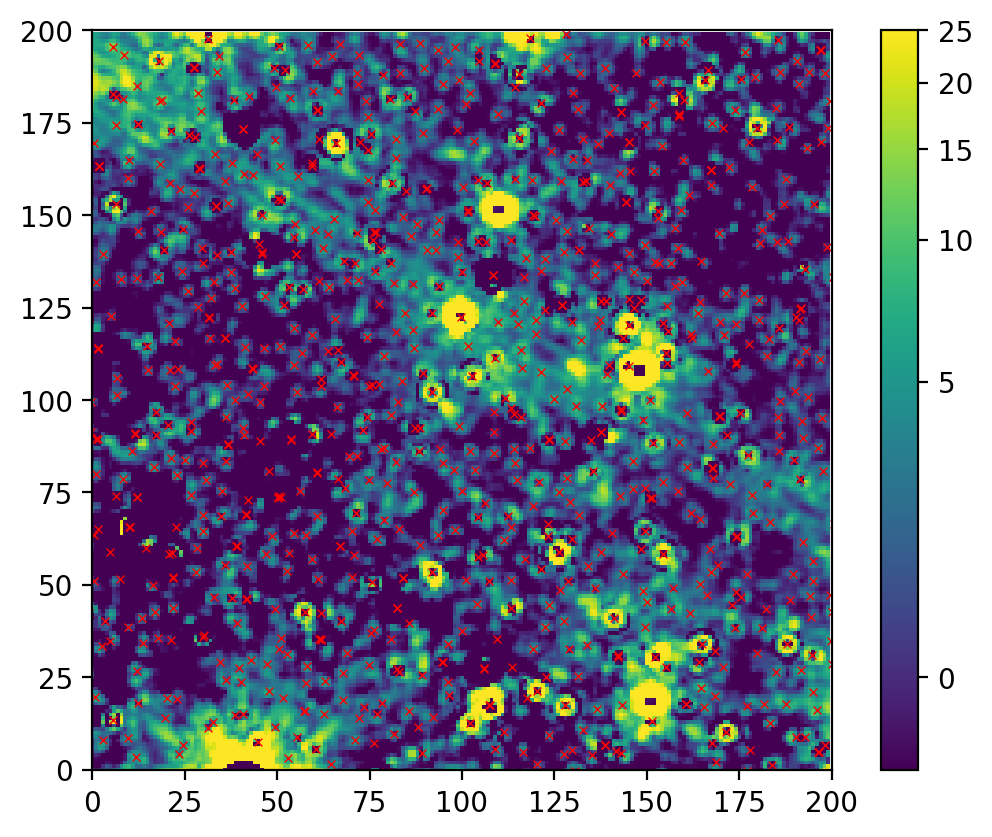

In [53]:
pl.figure(dpi=200)
pl.imshow(residual[slc], norm=simple_norm(residual, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

# iterative

In [54]:
phot_ = IterativePSFPhotometry(finder=daofind_tuned,
                               localbkg_estimator=LocalBackground(5, 15),
                               psf_model=dao_psf_model,
                               fitter=LevMarLSQFitter(),
                               maxiters=2,
                               fit_shape=(5, 5),
                               aperture_radius=2*fwhm_pix,
                               progress_bar=True
                              )

In [55]:
print("About to do ITERATIVE photometry....")
try:
    result2 = phot_(data, mask=mask)
except Exception as ex:
    print(ex)
    result2 = phot_(data)
    
#print(f"Done with ITERATIVE photometry. len(result2)={len(result2)}  dt={time.time() - t0}")
#coords2 = ww.pixel_to_world(result2['x_fit'], result2['y_fit'])

About to do ITERATIVE photometry....


Fit source/group:   0%|          | 0/3205 [00:00<?, ?it/s]

Add model sources:   0%|          | 0/3205 [00:00<?, ?it/s]

Fit source/group:   0%|          | 0/2721 [00:00<?, ?it/s]

In [56]:
residual_iter = phot_.make_residual_image(data, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/5926 [00:00<?, ?it/s]

In [57]:
model_iter = phot_.make_model_image(data.shape, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/5926 [00:00<?, ?it/s]

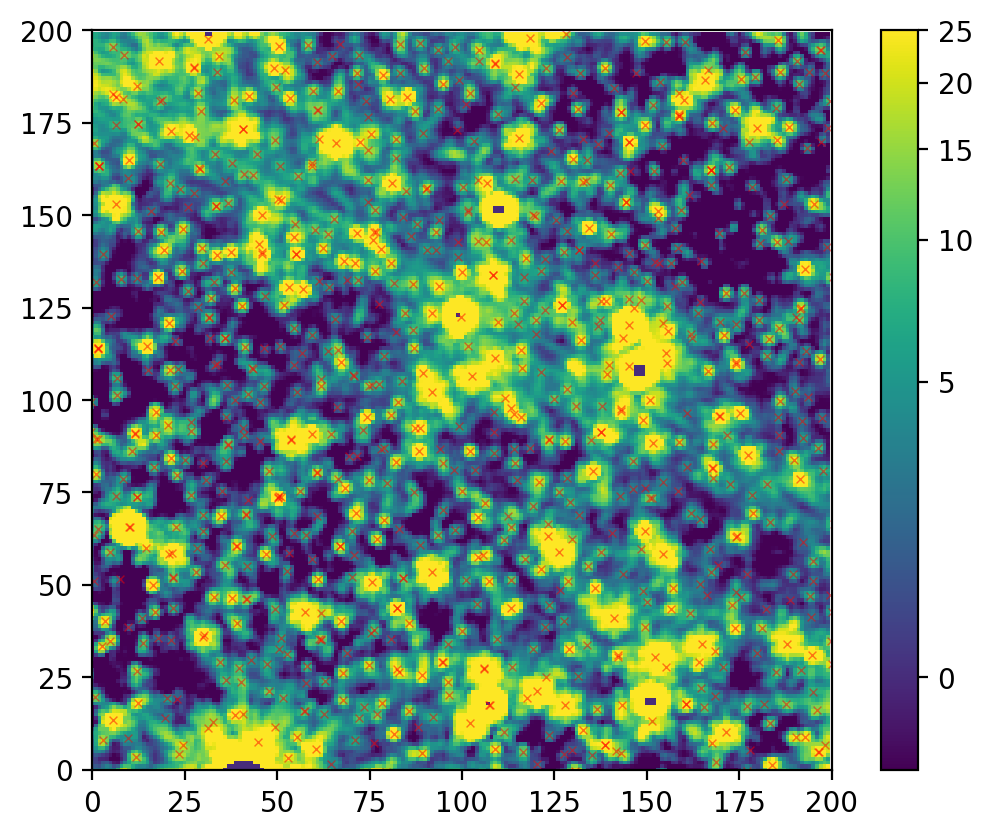

In [58]:
pl.figure(dpi=200)
pl.imshow(data[slc], norm=simple_norm(data, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8, alpha=0.5)
pl.axis([0,200,0,200]);

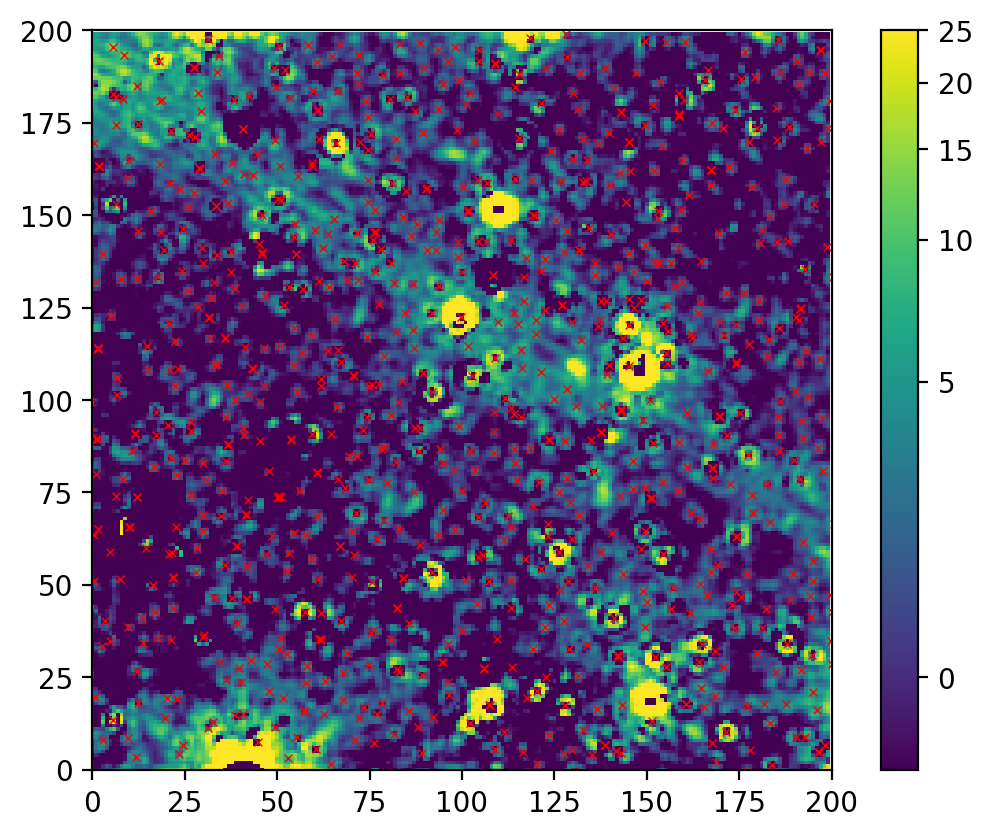

In [59]:
pl.figure(dpi=200)
pl.imshow(residual_iter[slc], norm=simple_norm(residual_iter, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);